## Importing all required libraries

In [ ]:
import pandas as pd
import re
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as stp
from sklearn.feature_extraction.text import CountVectorizer
# nltk.download()

## Reading dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Resume Ranker/Resume Ranking Data Set.csv')
df_cp = df.copy()

In [ ]:
df.head()

,accomplishments_segment,degree,education_segment,emails,job_titles,links,misc_segment,name,objectives_segment,phone,projects_segment,skills,skills_segment,text,university_0,university_1,university_2,university_3,university_4,university_5,url,work_experience,work_segment
0,NaN,"MS , B.TECH , PhD",NaN,sutarvinayak2063@gmail.com,"full stack developer , student","https://github.com/ramsuthar305/SIH2019 , http...",NaN,Prasad Nagar,NaN,+919309161108,NaN,"algorithms , interview , visualisation , robot...",NaN,VINAYAK \nSUTAR \nLinkedIn \n+91 9309161108 ...,"national, mainpuri, uttar pradesh","college of arts, sundargarh, odisha","school of engineering, ernakulam, kerala",NaN,NaN,NaN,https://training-resumes.s3.ap-south-1.amazona...,NaN,NaN
1,NaN,"B.E , MS , M.TECH",M.Tech. Data Science\nJSS Science And Technolo...,pooj.vs@gmail.com,software engineer,pooj.vs,06/2017 – 07/2019\n07/2018 – 07/2019\nmailto:p...,Software Engineer,NaN,7411786822,Oracle India Private Limited\nBengaluru\n,"core java , algorithms , sql tools , deep lear...",Looking forward to grasp new technologies.\npo...,POOJA V S\nSoftware Engineer\nRich exposure to...,"government, kandhamal, odisha","vidya vardhaka college of engineering, mysore,...",NaN,NaN,NaN,NaN,https://training-resumes.s3.ap-south-1.amazona...,NaN,Merchandising System' using PL/SQL.\nmaintain ...
2,Successfully cleared and completed the course ...,"MS , B.TECH , BS",Degree\nInstitute\nBoard/University\nYear\nPer...,khandelwal.ashwin5@gmail.com,NaN,https://www.linkedin.com/in/ashwin-khandelwal-...,NaN,Ashwin Khandelwal,"I seek challenging environment to work in, tha...",9462710290,Description\nInfogain \n(July 2019 - Present)\...,"digital signal processing , algorithms , capac...",NaN,Ashwin Khandelwal \n Email id – khand...,"narsee monjee institute of management studies,...",NaN,NaN,NaN,NaN,NaN,https://training-resumes.s3.ap-south-1.amazona...,NaN,Organization / Institute\nDescription\nBharat ...
3,NaN,"B.E , MS , BS",NaN,NaN,"work from home , support analyst , software an...",NaN,NaN,Computer Engineering,NaN,919930485336,NaN,"big data analytics , award , training , comput...",NaN,Assessment\nQ1. Why should you be hired for th...,"master, medak, telangana",NaN,NaN,NaN,NaN,NaN,https://training-resumes.s3.ap-south-1.amazona...,1.0,NaN
4,NaN,"MS , B.TECH , BS",NaN,NaN,"work from home , classifier",https://github.com/ajay1013/Titanic-ML-from-Di...,NaN, Python,NaN,918010295832,NaN,"functionality , algorithms , spark , data visu...",NaN,Assessment\nQ1. Why should you be hired for th...,"greater noida institute of technology, gautam ...",NaN,NaN,NaN,NaN,NaN,https://training-resumes.s3.ap-south-1.amazona...,NaN,NaN


## Total null values of each Features

In [ ]:
df.isnull().sum()

accomplishments_segment    1507
degree                       38
education_segment          1116
emails                     1509
job_titles                   27
links                       354
misc_segment               1551
name                          1
objectives_segment         1159
phone                       219
projects_segment            893
skills                        0
skills_segment             1105
text                          0
university_0               1007
university_1               1305
university_2               1480
university_3               1545
university_4               1568
university_5               1571
url                           0
work_experience             854
work_segment                893
dtype: int64

## Dropping the features which doesn't required

In [ ]:
df.drop(['accomplishments_segment','education_segment','emails','misc_segment','name','objectives_segment','phone','projects_segment','skills_segment','text',
         'university_0','university_1','university_2','university_3','university_4','university_5','url','work_segment'],axis=1,inplace=True)
df.shape

(1573, 5)

## Total null values of features after dropping the features

In [ ]:
print('After removing the columns from dataset..')
df.isnull().sum()

After removing the columns from dataset..


degree              38
job_titles          27
links              354
skills               0
work_experience    854
dtype: int64

## Handling null values of features

In [ ]:
df['degree'].fillna(df.degree.mode()[0],inplace=True)
df['links'].fillna('Missing',inplace=True)
df['work_experience'].fillna(0,inplace=True)
df['job_titles'].fillna('No Job',inplace=True)

## Fetching the unique value from the 'degree' feature

In [ ]:
all_degrees = ''
for i in df.degree:
  if len(all_degrees) == 0:
    all_degrees = i
  else:
    all_degrees = all_degrees + ' , ' + i

all_degrees = all_degrees.split(',')
all_degrees = [re.sub("[\s.]","",i).upper() for i in all_degrees]
unique_degrees = set(all_degrees)
unique_degrees

{'BE', 'BS', 'BSC', 'BTECH', 'ME', 'MS', 'MSC', 'MTECH', 'PHD'}

## Feature Handling of 'degree', 'links' and 'work_experience'

In [ ]:
df['bachelor_degrees'] = 'No Degree'
df['master_degrees'] = 'No Degree'
df['docterte_degrees'] = 'No Degree'
df['profiles'] = 'No Profile'

### 1. 'degree' convert into 'bachelor', 'master', and 'docterte'

In [ ]:
ind = 0
for i in df.degree:  
  lst = re.sub("[\s.]","",i).upper( )
  # print(lst)
  for j in lst.split(','):
    if j in ['BE', 'BS', 'BSC', 'BTECH']:
      if df.loc[ind,'bachelor_degrees'] == 'No Degree':
        df.loc[ind,'bachelor_degrees'] = j
      else:
        df.loc[ind,'bachelor_degrees'] = df.loc[ind,'bachelor_degrees'] + ' , '+ j
    elif j in ['ME', 'MS', 'MSC', 'MTECH']:      
      if df.loc[ind,'master_degrees'] == 'No Degree':
        df.loc[ind,'master_degrees'] = j
      else:
        df.loc[ind,'master_degrees'] = df.loc[ind,'master_degrees'] + ' , '+ j
    elif j == 'PHD':      
      if df.loc[ind,'docterte_degrees'] == 'No Degree':
        df.loc[ind,'docterte_degrees'] = j
      else:
        df.loc[ind,'docterte_degrees'] = df.loc[ind,'docterte_degrees'] + ' , '+ j
  ind +=1

In [ ]:
df

,degree,job_titles,links,skills,work_experience,bachelor_degrees,master_degrees,docterte_degrees,profiles
0,"MS , B.TECH , PhD","full stack developer , student","https://github.com/ramsuthar305/SIH2019 , http...","algorithms , interview , visualisation , robot...",0.0,BTECH,MS,PHD,No Profile
1,"B.E , MS , M.TECH",software engineer,pooj.vs,"core java , algorithms , sql tools , deep lear...",0.0,BE,"MS , MTECH",No Degree,No Profile
2,"MS , B.TECH , BS",No Job,https://www.linkedin.com/in/ashwin-khandelwal-...,"digital signal processing , algorithms , capac...",0.0,"BTECH , BS",MS,No Degree,No Profile
3,"B.E , MS , BS","work from home , support analyst , software an...",Missing,"big data analytics , award , training , comput...",1.0,"BE , BS",MS,No Degree,No Profile
4,"MS , B.TECH , BS","work from home , classifier",https://github.com/ajay1013/Titanic-ML-from-Di...,"functionality , algorithms , spark , data visu...",0.0,"BTECH , BS",MS,No Degree,No Profile
...,...,...,...,...,...,...,...,...,...
1568,"B.E , MS , M.TECH","branch manager , embedded software developer ,...","https://www.linkedin.com/in , https://grv20.gi...","digital communication , api , atom , robot , c...",2.0,BE,"MS , MTECH",No Degree,No Profile
1569,"MS , BS","devops , senior android developer , team lead","com.gokada , https://play.google.com/store/app...","reporting , functionality , socket.io , mockit...",2.0,BS,MS,No Degree,No Profile
1570,"B.S , M.Sc , M.S , BS , MS","devops engineer , traffic manager , release ma...",https://freesearch.naukri.com/preview/printResume,"version control , renewals , nfs , telugu , vi...",12.0,"BS , BS","MSC , MS , MS",No Degree,No Profile
1571,MS,classifier,Missing,"natural language , matplotlib , boost , custom...",0.0,No Degree,MS,No Degree,No Profile


### 2. 'links' convert into 'profile'

In [ ]:
ind = 0
for i in df.links:
  lst = re.sub("[\s]","",i)
  # print(lst)
  for j in lst.split(','):
    if j.find('github') != -1:          
      df.loc[ind,'profiles'] = 'Github'
    elif j.find('linkedin') != -1:
      if df.loc[ind,'profiles'] == 'No Profile':
        df.loc[ind,'profiles'] = 'Linkedin'
      else:
        df.loc[ind,'profiles'] = df.loc[ind,'profiles'] + ' , ' + 'Linkedin'
  ind +=1

In [ ]:
df

,degree,job_titles,links,skills,work_experience,bachelor_degrees,master_degrees,docterte_degrees,profiles
0,"MS , B.TECH , PhD","full stack developer , student","https://github.com/ramsuthar305/SIH2019 , http...","algorithms , interview , visualisation , robot...",0.0,BTECH,MS,PHD,Github
1,"B.E , MS , M.TECH",software engineer,pooj.vs,"core java , algorithms , sql tools , deep lear...",0.0,BE,"MS , MTECH",No Degree,No Profile
2,"MS , B.TECH , BS",No Job,https://www.linkedin.com/in/ashwin-khandelwal-...,"digital signal processing , algorithms , capac...",0.0,"BTECH , BS",MS,No Degree,Linkedin
3,"B.E , MS , BS","work from home , support analyst , software an...",Missing,"big data analytics , award , training , comput...",1.0,"BE , BS",MS,No Degree,No Profile
4,"MS , B.TECH , BS","work from home , classifier",https://github.com/ajay1013/Titanic-ML-from-Di...,"functionality , algorithms , spark , data visu...",0.0,"BTECH , BS",MS,No Degree,Github
...,...,...,...,...,...,...,...,...,...
1568,"B.E , MS , M.TECH","branch manager , embedded software developer ,...","https://www.linkedin.com/in , https://grv20.gi...","digital communication , api , atom , robot , c...",2.0,BE,"MS , MTECH",No Degree,"Github , Linkedin"
1569,"MS , BS","devops , senior android developer , team lead","com.gokada , https://play.google.com/store/app...","reporting , functionality , socket.io , mockit...",2.0,BS,MS,No Degree,No Profile
1570,"B.S , M.Sc , M.S , BS , MS","devops engineer , traffic manager , release ma...",https://freesearch.naukri.com/preview/printResume,"version control , renewals , nfs , telugu , vi...",12.0,"BS , BS","MSC , MS , MS",No Degree,No Profile
1571,MS,classifier,Missing,"natural language , matplotlib , boost , custom...",0.0,No Degree,MS,No Degree,No Profile


### 3. handling the null values of work_experience and converted it's all data into integer format

In [ ]:
# list(df['work_experience'].unique())
df.work_experience.value_counts()

 0.0       854
 4.0       151
 2.0        91
 1.0        87
 3.0        81
 5.0        73
 6.0        52
 8.0        34
 7.0        32
 9.0        23
 14.0       14
 11.0       12
 10.0       12
 12.0       11
 13.0        6
 18.0        5
 15.0        4
 17.0        4
 21.0        4
 20.0        2
 22.0        2
 16.0        2
 2006.0      2
 2005.0      2
 2004.0      2
 2003.0      2
-3.0         1
 2001.0      1
 19.0        1
 2013.0      1
 1999.0      1
 2010.0      1
 2002.0      1
 2008.0      1
 2012.0      1
Name: work_experience, dtype: int64

In [ ]:
ind = 0
for i in df.work_experience:
  if i < 0:
    df.loc[ind,'work_experience'] = i*-1
  elif i > 40:
    df.loc[ind,'work_experience'] = 0
  ind +=1
df['work_experience'] = df['work_experience'].astype(int)  

## Removing the 'degree' and 'links' from the dataset after feature handling

In [ ]:
df.drop(['degree','links'],axis=1,inplace=True)

In [ ]:
df.isnull().sum()
df

,job_titles,skills,work_experience,bachelor_degrees,master_degrees,docterte_degrees,profiles
0,"full stack developer , student","algorithms , interview , visualisation , robot...",0,BTECH,MS,PHD,Github
1,software engineer,"core java , algorithms , sql tools , deep lear...",0,BE,"MS , MTECH",No Degree,No Profile
2,No Job,"digital signal processing , algorithms , capac...",0,"BTECH , BS",MS,No Degree,Linkedin
3,"work from home , support analyst , software an...","big data analytics , award , training , comput...",1,"BE , BS",MS,No Degree,No Profile
4,"work from home , classifier","functionality , algorithms , spark , data visu...",0,"BTECH , BS",MS,No Degree,Github
...,...,...,...,...,...,...,...
1568,"branch manager , embedded software developer ,...","digital communication , api , atom , robot , c...",2,BE,"MS , MTECH",No Degree,"Github , Linkedin"
1569,"devops , senior android developer , team lead","reporting , functionality , socket.io , mockit...",2,BS,MS,No Degree,No Profile
1570,"devops engineer , traffic manager , release ma...","version control , renewals , nfs , telugu , vi...",12,"BS , BS","MSC , MS , MS",No Degree,No Profile
1571,classifier,"natural language , matplotlib , boost , custom...",0,No Degree,MS,No Degree,No Profile


## Defining the functions to calculate the rank of the resume 

In [ ]:
lemmatizer = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (lemmatizer.lemmatize(w,get_wordnet_pos(w)) for w in analyzer(doc) if w not in set(stp.words('english')))        

In [ ]:
def get_wordnet_pos(word):    
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
def get_tf_idf_cosine_similarity(job_desc,all_resumes):    
    tf_idf_vect = TfidfVectorizer(analyzer=stemmed_words)
    tf_idf_desc_vector = tf_idf_vect.fit_transform([job_desc]).todense()
    tf_idf_resume_vector = tf_idf_vect.transform(all_resumes).todense()
    cosine_similarity_list = []
    for i in range(len(tf_idf_resume_vector)):
        cosine_similarity_list.append(cosine_similarity(tf_idf_desc_vector,tf_idf_resume_vector[i])[0][0])
    return cosine_similarity_list    

## Opening the Job Description from the text file

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Resume Ranker/Job Description.txt','r',encoding = 'utf-8') as f:
  file_desc_lst =  [r.replace('\n', '') for r in f.readlines()]

In [ ]:
job_description = ''

for i in file_desc_lst:
  if len(job_description) == 0:
    job_description = str(i)
  else:
    job_description = job_description + ' ' + str(i)  

## Reading all resume's from the dataset and convert into text which will appended into a list

In [ ]:
all_resume_text = []

for i in df.iloc[:].values:
  s = ''
  for j in list(i):
    if len(s) == 0:
      s = str(j)
    else:
      s = s + ' , ' + str(j)
  all_resume_text.append(s)

## Call 'get_tf_idf_cosine_similarity' function which will give us the cosine score

In [ ]:
cos_sim_list = get_tf_idf_cosine_similarity(job_description,all_resume_text)

In [ ]:
zipped_resume_rating = zip(cos_sim_list,df_cp.name,[x for x in range(len(df))])
sorted_resume_rating_list = sorted(zipped_resume_rating, key = lambda x: x[0], reverse=True)

## Generating the DataFrame which contains the name of the candidate with his/her cosine score(%)

In [ ]:
resume_score = [round(x*100,2) for x in cos_sim_list]
pd.concat([df_cp.name,pd.DataFrame(resume_score,columns=['resume_score(%)'])],axis=1).sort_values(by=['resume_score(%)'],ascending=False).head(10)

,name,resume_score(%)
464,Rucha Patwardhan,59.38
1542,Technical Architect,51.72
1095,Cloud Infrastructure,51.66
98,Microsoft Word,50.84
75,Credit Card,47.37
852,IT Software,46.55
869,Cloud Data,46.54
236,Deep Learning,46.12
487,Sahil Kadian,46.01
544,Deep Learning,45.95


In [1]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


/tmp/ipykernel_1910364/363409568.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x=list(execution_times.keys()), y=list(execution_times.values()), palette="Blues")


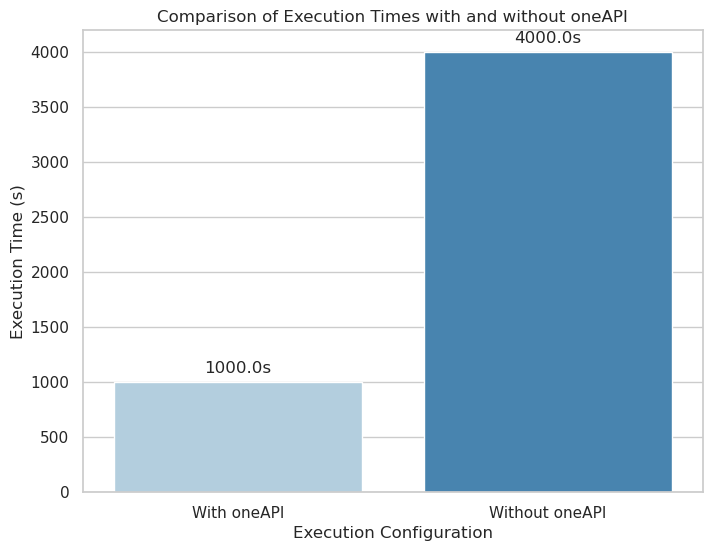

In [1]:
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Simulate execution times with and without oneAPI
execution_times = {'With oneAPI': 1000, 'Without oneAPI': 4000}

# Create a Seaborn bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plot = sns.barplot(x=list(execution_times.keys()), y=list(execution_times.values()), palette="Blues")

# Annotate the bars with the respective values
for p in plot.patches:
    plot.annotate(f'{p.get_height()}s', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set plot labels and title
plt.xlabel('Execution Configuration')
plt.ylabel('Execution Time (s)')
plt.title('Comparison of Execution Times with and without oneAPI')

# Show the plot
plt.show()